In this notebook, I will run various machine learning experiments where I will use `rest_name` to predict expert `menu healthiness scores`. The best performing model will be saved for each experiment.

Below is a summary of what I am going to do in this notebook:

**Data Cleaning**
- remove special characters, puncutuations
- remove chain locations (did not end up doing)
- split train test sets


**ML/DL experiments**
- **Model 0 (ML)**: Baseline model with only rest_name (Support Vector Regression, tf-idf)
- **Model 1 (DL)**: LSTM model with word level tokenization
- **Model 2 (DL)**: LSTM model with character level tokenization
- **Model 3 (DL)**: GRU model with word level tokenization
- **Model 4 (DL)**: GRU model with character level tokenization
- **Model 5 (DL)**: CNN model with word level tokenization
- **Model 6 (transfer learning)**: pre-trained embedding layer (ULM)
- **Model 7 (transfer learning)**: pre-trained embedding layer and fine tuning.
- **Model 8 (DL)**: GRU model with word level tokenization, added food hygiene rating
- **Model 9 (DL)**: GRU model with character level tokenization, added food hygiene rating
- **Model 10 (DL)**: GRU model with character level tokenization, added food hygiene rating, and changed the activation


## Data preprocessing

In [ ]:
## Import all the libraries
# !pip install unidecode
from unidecode import unidecode
import string
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, f1_score, accuracy_score,classification_report,explained_variance_score, r2_score, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
import seaborn as sns
#!pip install smogn
from collections import Counter
from joblib import dump, load

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 5.0 MB/s 


## Examine the data

In [ ]:
train_ds = pd.read_csv('train_smogn.csv')
test_ds = pd.read_csv('test_smogn.csv')

In [ ]:
train_ds.shape, test_ds.shape

((56902, 25), (5458, 26))

In [ ]:
# 0-12 if over 12 then 12
def clean_data(data):
  data.loc[data['predict']>12, 'predict'] = 12
  data.loc[data['predict']<0, 'predict'] = 0
  return data

In [ ]:
train_ds = clean_data(train_ds)
test_ds = clean_data(test_ds)

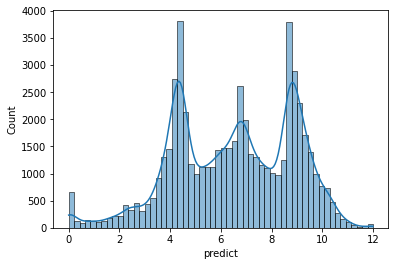

In [ ]:
sns.histplot(train_ds.predict,kde=True)

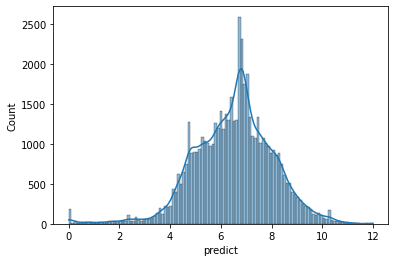

In [ ]:
sns.histplot(justeat_menu.predict,kde=True)

## Clean the data

### remove/replace punctuations


In [ ]:
def rest_name_cleaning(rest_name):
  '''
  This function cleans the restaurant name string
  '''
  rest_name_clean = rest_name.lower()
  rest_name_clean = rest_name_clean.strip()
  ascii_name = unidecode(rest_name_clean)
  ascii_name_fix = ascii_name.replace('`',"'")
  ascii_name_fix = ascii_name_fix.replace('~'," ")
  ascii_name_fix = ascii_name_fix.replace(']'," ")
  ascii_name_fix = ascii_name_fix.replace('['," ")
  ascii_name_fix = ascii_name_fix.replace('\\'," ")
  ascii_name_fix = ascii_name_fix.replace('%'," ")
  ascii_name_fix = ascii_name_fix.replace('*'," ")
  ascii_name_fix = ascii_name_fix.replace('+'," and ")
  ascii_name_fix = ascii_name_fix.replace('&'," and ")
  ascii_name_fix = ascii_name_fix.replace('/'," ")

  return ascii_name_fix

In [ ]:
train_ds['ascii_name_fix'] = train_ds.rest_name.apply(lambda x: rest_name_cleaning(x))
test_ds['ascii_name_fix'] = test_ds.rest_name.apply(lambda x: rest_name_cleaning(x))

In [ ]:
train_ds

,Unnamed: 0,index,Restaurant ID,Desserts,Vegetables,Salads,Chips,Water,Milk,Special Offers,...,price_min,price_max,postcode,postcode_district,specialOffers,chips,salads,predict,rating2,ascii_name_fix
0,0,21615,37196,1,18,4,1,0,0,3,...,0.317419,44.105129,G12 8TN,G12,3,1,4,8.568073,3,la vita spuntini
1,1,21158,38498,1,18,4,2,0,0,3,...,0.330876,44.440739,G12 8TN,G12,3,1,4,8.556266,2,la vita spuntini
2,2,20740,35972,2,17,5,2,0,0,3,...,0.300338,44.254935,G12 8TN,G12,2,2,5,8.546312,3,la vita spuntini
3,3,25787,95230,0,17,2,0,0,0,4,...,2.949059,120.214755,G12 8TN,G12,4,0,2,8.555663,3,la vita spuntini
4,4,26378,94912,0,16,3,0,0,0,4,...,2.933776,119.953226,G12 8TN,G12,4,0,2,8.538543,3,la vita spuntini
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56897,11805,35652,136390,0,6,0,28,0,0,20,...,0.513422,24.900960,NE5 5BS,NE5,9,14,0,4.446339,0,sugar shack
56898,11806,15334,93479,2,7,1,13,0,0,12,...,0.393716,36.147208,NE5 5BS,NE5,9,12,1,4.515520,0,sugar shack
56899,11807,34316,105749,62,5,1,5,0,0,1,...,0.320822,13.762017,NE5 5BS,NE5,0,4,1,3.321277,0,sugar shack
56900,11808,44254,104782,3,8,2,13,0,0,11,...,0.476740,20.117191,NE5 5BS,NE5,9,12,2,4.576050,0,sugar shack


In [ ]:
X_train = train_ds.ascii_name_fix
y_train = train_ds.predict
X_test_ = test_ds.ascii_name_fix
y_test_ = test_ds.predict

In [ ]:
from sklearn.model_selection import train_test_split
# now split the test and validation set (5% each, and 90% for training)
X_test, X_val, y_test, y_val = train_test_split(X_test_, y_test_, random_state = 42, test_size = 0.5)

In [ ]:
X_train.shape, X_test.shape, X_val.shape

((56902,), (2729,), (2729,))

# READY FOR MODEL TRAINING!!

## Model 0 (ML): Baseline model

Using support vector regression (benchmark) only

In [3]:
# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("svr", SVR()) # model the scores
])

# Fit the pipeline to the training data
model_0.fit(X_train,y_train)

In [ ]:
from joblib import dump
dump(model_0, 'model_0_190722_resampled.joblib')

['model_0_190722_resampled.joblib']

In [ ]:
from joblib import load
model_0 = load('model_0_190722_resampled.joblib')
#-> model with average values from food outlets with the same name (should we?)

I have done hyperparameter tuning and the best performing model has the default parameters (In notebook `06_Applying_the_Model.ipynb`).

> `Best parameter (CV score=0.409):
{'svr__C': 1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}`



In [ ]:
# Evaluate the model performance on test set

# set up model prediction and metrics
def evaluate_preds(model_name, y_true, X_test):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = model_name.predict(X_test)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}


In [ ]:
evaluate_preds(model_0, y_train, X_train)

{'mae': 0.5939533, 'mape': 39683576.0, 'mse': 0.9335126, 'rmse': 0.96618456}

In [ ]:
evaluate_preds(model_0, y_test, X_test)

{'mae': 0.86366796, 'mape': 10981583.0, 'mse': 1.4286658, 'rmse': 1.195268}

In [ ]:
# If we assume mean values for prediction, what would the outcome be?
mean_absolute_error(y_test,[np.mean(y_train.to_list())]*len(y_test)) #if we assume mean values

1.1863973972209403

### some prediction examples

In [ ]:
# prediction examples
names_to_predict = ['X\'s fish & chip shop', 'Yuru\'s Pizza & Kebab', 'Yuru\'s Chinese Takeaways','Yuru\'s Sushi Takeaways','Yuru\'s Sushi Restaurant','Yuru\'s Cocktail Bar',
                    'Cambridge Oven','Yo!Sushi','Starbucks','Vanderlyle']
names_to_predict2 = [rest_name_cleaning(name) for name in names_to_predict]
pd.DataFrame(zip(names_to_predict,model_0.predict(names_to_predict2)),columns=['rest_name','predicted_score'])

,rest_name,predicted_score
0,X's fish & chip shop,5.121290
1,Yuru's Pizza & Kebab,4.941605
2,Yuru's Chinese Takeaways,6.452868
3,Yuru's Sushi Takeaways,10.234860
4,Yuru's Sushi Restaurant,11.225519
5,Yuru's Cocktail Bar,6.586805
6,Cambridge Oven,7.005949
7,Yo!Sushi,9.475604
8,Starbucks,7.416714
9,Vanderlyle,5.922581


### Set up model callbacks

Create a small function to create a ModelCheckpoint callback which saves a model to specified filename. Because we are going to run multiple experiments, we will keep track of them (save the best model)

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            save_best_only=True, verbose=0) # save only the best model to file

# create a function for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3, restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

##Model 1 (DL): LSTM model, word level tokenization


In [ ]:
# create tensorflow datasets for training
X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_test = tf.data.Dataset.from_tensor_slices(X_test)
X_val = tf.data.Dataset.from_tensor_slices(X_val)

In [ ]:
y_train =tf.data.Dataset.from_tensor_slices(y_train)
y_test =tf.data.Dataset.from_tensor_slices(y_test)
y_val = tf.data.Dataset.from_tensor_slices(y_val)

In [ ]:
train_ds_word =  tf.data.Dataset.zip((X_train,y_train))
test_ds_word =  tf.data.Dataset.zip((X_test,y_test))
val_ds_word =  tf.data.Dataset.zip((X_val,y_val))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
train_ds_word = train_ds_word.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)
test_ds_word = test_ds_word.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)
val_ds_word =val_ds_word.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

###Word level tokenization

In [ ]:
max_vocab_length=20000
max_length = 10 # max length our sequences will be (e.g. how many words from the restaurant name does our model see?)

word_vectorizer = TextVectorization(output_mode="int",
                                    max_tokens = max_vocab_length,
                                    split = "whitespace",
                                    standardize ="lower_and_strip_punctuation",
                                    output_sequence_length=max_length)

In [ ]:
# Find average number of tokens (words) in training restaurant names
round(sum([len(i.split()) for i in X_train])/len(X_train)), max([len(i.split()) for i in X_train])

(3, 10)

In [ ]:
# Fit the text vectorizer to the training text
word_vectorizer.adapt(X_train)

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = word_vectorizer.get_vocabulary()
top_10_words = words_in_vocab[:10] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_10_words = words_in_vocab[-10:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 10 most common words: {top_10_words}")
print(f"Bottom 10 least common words: {bottom_10_words}")

Number of words in vocab: 14403
Top 10 most common words: ['', '[UNK]', 'la', 'vita', 'spuntini', 'shack', 'sugar', 'and', 'pizza', 'the']
Bottom 10 least common words: ['110118', '1093', '107', '1066', '106', '105', '102104', '1018a', '1016', '1012']


### model 1 (in action)

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
model_1_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=64,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_1")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = word_vectorizer(inputs)
x = model_1_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in restaurant name (you can stack RNN cells as long as return_sequences=True)
# x = tf.keras.layers.Dropout(.2)(x)
x = layers.LSTM(64)(x) # return vector for whole sequence
x = layers.Flatten()(x)
x = tf.keras.layers.Dropout(.2)(x)
x = layers.Dense(64, activation="relu")(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_LSTM_word")
model_1.summary()

(None, 10, 64)
Model: "model_1_LSTM_word"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 10)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 10, 64)            1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                  

In [ ]:
%%time

model_1.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())
model_1_history = model_1.fit(train_ds_word, epochs=25, validation_data = val_ds_word,
                              callbacks=[create_model_checkpoint(model_name='model_1_LSTM_word'),early_stopping])

Epoch 1/25
1777/1778 [============================>.] - ETA: 0s - loss: 0.9622

INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


1778/1778 [==============================] - 15s 7ms/step - loss: 0.9620 - val_loss: 1.0194
Epoch 2/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.7076 - val_loss: 1.4471
Epoch 3/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.6059 - val_loss: 1.0855
Epoch 4/25
1772/1778 [============================>.] - ETA: 0s - loss: 0.5405

INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.5412 - val_loss: 0.8997
Epoch 5/25
1772/1778 [============================>.] - ETA: 0s - loss: 0.5023

INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.5031 - val_loss: 0.8874
Epoch 6/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.4845 - val_loss: 0.8950
Epoch 7/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.4700 - val_loss: 0.9059
Epoch 8/25
1767/1778 [============================>.] - ETA: 0s - loss: 0.4565

INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


1778/1778 [==============================] - 13s 8ms/step - loss: 0.4586 - val_loss: 0.8801
Epoch 9/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.4361 - val_loss: 0.8974
Epoch 10/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.4306 - val_loss: 0.8987
Epoch 11/25
1769/1778 [============================>.] - ETA: 0s - loss: 0.4243

INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.4262 - val_loss: 0.8796
Epoch 12/25
1775/1778 [============================>.] - ETA: 0s - loss: 0.4206

INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


1778/1778 [==============================] - 15s 8ms/step - loss: 0.4211 - val_loss: 0.8765
Epoch 13/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.4201 - val_loss: 0.8782
Epoch 14/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.4172 - val_loss: 0.8979
Epoch 15/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.4073 - val_loss: 0.9012
CPU times: user 3min 4s, sys: 13.8 s, total: 3min 17s
Wall time: 2min 55s


In [ ]:
import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [Menu Healthiness]')
  plt.legend()
  plt.grid(True)

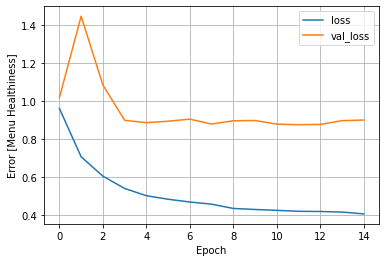

In [ ]:
plot_loss(model_1_history)

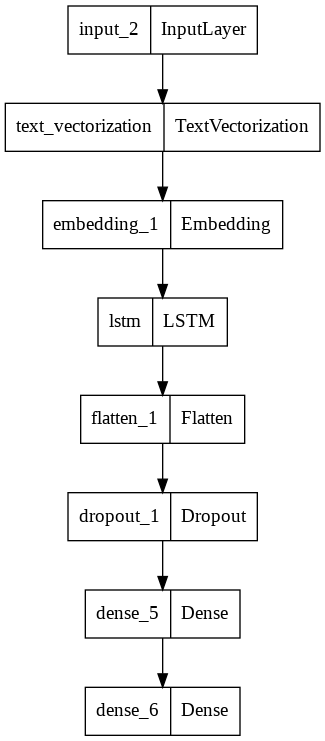

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_1)

In [ ]:
# Evaluate model on validation data
def model_evaluation(model_name):
  model= tf.keras.models.load_model(f"model_experiments/{model_name}")
  print('results from the training')
  model.evaluate(train_ds_word)
  print('results from the validation set')
  model.evaluate(val_ds_word)
  print('results from the test set')
  model.evaluate(test_ds_word)

In [ ]:
model_evaluation('model_1_LSTM_word')

results from the training
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6555
results from the validation set
85/85 [==============================] - 1s 12ms/step - loss: 0.8765
results from the test set
85/85 [==============================] - 1s 12ms/step - loss: 0.8727


In [ ]:
pd.DataFrame(zip(names_to_predict,model_1.predict(names_to_predict2)),columns=['rest_name','predicted_score'])

,rest_name,predicted_score
0,X's fish & chip shop,[6.843343]
1,Yuru's Pizza & Kebab,[5.6181097]
2,Yuru's Chinese Takeaways,[6.8789444]
3,Yuru's Sushi Takeaways,[8.5164995]
4,Yuru's Sushi Restaurant,[8.7171755]
5,Yuru's Cocktail Bar,[6.4798574]
6,Cambridge Oven,[5.2081327]
7,Yo!Sushi,[6.886839]
8,Starbucks,[7.2835846]
9,Vanderlyle,[6.886839]


## Model 2 (DL): LSTM model, character level tokenization

### character level tokenization

In [ ]:
# set up character level tokenization
max_features = 39          # Number of distinct chars
sequence_length = 57       # Input sequence size

def char_split(input_data):
  return(tf.strings.unicode_split(input_data,'UTF-8'))

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    split=char_split, # word_split or char_split
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [ ]:
batch_size = 32
vectorize_layer.adapt(X_train.batch(batch_size))

In [ ]:
# Average number of characters in the restaurant name
round(sum([len(tf.strings.unicode_split(i,"UTF-8")) for i in X_train])/len(X_train))

16

In [ ]:
# Maximum number of characters in the restaurant name
max([len(tf.strings.unicode_split(i,"UTF-8")) for i in X_train])

In [ ]:
def vectorize_text(text):
  text = tf.expand_dims(text, -1)
  return tf.squeeze(vectorize_layer(text))

In [ ]:
vectorize_text('Yuru chinese best')

<tf.Tensor: shape=(57,), dtype=int64, numpy=
array([23, 10,  9, 10,  2, 13, 12,  4,  6,  8,  5,  8,  2, 20,  8,  5,  7,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])>

In [ ]:
# vectorize the training and test set for building the model
X_train_char = X_train.map(vectorize_text)
X_val_char = X_val.map(vectorize_text)
X_test_char = X_test.map(vectorize_text)

In [ ]:
train_ds_char =  tf.data.Dataset.zip((X_train_char,y_train))
AUTOTUNE = tf.data.AUTOTUNE
train_ds_char = train_ds_char.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
val_ds_char =  tf.data.Dataset.zip((X_val_char,y_val))
val_ds_char = val_ds_char.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)
test_ds_char =  tf.data.Dataset.zip((X_test_char,y_val))
test_ds_char = test_ds_char.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)

inputs = tf.keras.Input(shape=(sequence_length), dtype="int64")

x = layers.Embedding(max_features,output_dim=64,embeddings_initializer="uniform",
                                     name="embedding_2")(inputs)

x = layers.LSTM(64, return_sequences=True)(x)
x = layers.Flatten()(x)
x = tf.keras.layers.Dropout(.2)(x)
#x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM_char")
model_2.summary()

Model: "model_2_LSTM_char"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 57)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 57, 64)            2496      
                                                                 
 lstm_14 (LSTM)              (None, 57, 64)            33024     
                                                                 
 flatten_12 (Flatten)        (None, 3648)              0         
                                                                 
 dropout_11 (Dropout)        (None, 3648)              0         
                                                                 
 dense_28 (Dense)            (None, 1)                 3649      
                                                                 
Total params: 39,169
Trainable params: 39,169
Non

In [1]:
model_2.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())
model_2_history = model_2.fit(train_ds, epochs=25, validation_data =val_ds,
                              callbacks=[create_model_checkpoint(model_name=model_2.name),early_stopping])

In [ ]:
plot_loss(model_2_history)

In [ ]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_LSTM_char")

In [ ]:
model_2.evaluate(train_ds)

In [ ]:
model_2.evaluate(val_ds)

##Model 3(DL): GRU, word level

Another popular and effective RNN component is the GRU or gated recurrent unit.The GRU cell has similar features to an LSTM cell but has less parameters.

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=64,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = word_vectorizer(inputs)
x = model_3_embedding(x)
x= layers.GRU(64)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1)(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU_word")

In [ ]:
model_3.summary()

Model: "model_3_GRU_word"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 10)               0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 10, 64)            1280000   
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                  

In [ ]:
model_3.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())
model_3_history = model_3.fit(train_ds_word, epochs=25, validation_data = val_ds_word,
                              callbacks=[create_model_checkpoint(model_name=model_3.name), early_stopping])

In [ ]:
plot_loss(model_3_history)

In [ ]:
model_evaluation("model_3_GRU_word")

In [ ]:
pd.DataFrame(zip(names_to_predict,model_3.predict(names_to_predict2)),columns=['rest_name','predicted_score'])

## Model 4 (DL): GRU, character level

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)

inputs = tf.keras.Input(shape=(sequence_length), dtype="int64")

x = layers.Embedding(max_features,output_dim=64,embeddings_initializer="uniform",
                                     name="embedding_4")(inputs)

x = layers.GRU(64, return_sequences=True)(x)
x = layers.Flatten()(x)
x= layers.Dropout(0.2)(x)
#x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1)(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_GRU_char")
model_4.summary()

Model: "model_4_GRU_char"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 57)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 57, 64)            2496      
                                                                 
 gru_7 (GRU)                 (None, 57, 64)            24960     
                                                                 
 flatten_13 (Flatten)        (None, 3648)              0         
                                                                 
 dropout_12 (Dropout)        (None, 3648)              0         
                                                                 
 dense_29 (Dense)            (None, 1)                 3649      
                                                                 
Total params: 31,105
Trainable params: 31,105
Non-

In [ ]:
model_4.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ['mae'])

model_4_history = model_4.fit(train_ds, epochs=25, validation_data = val_ds,
                              callbacks=[create_model_checkpoint(model_name=model_4.name), early_stopping])

Epoch 1/25
1775/1778 [============================>.] - ETA: 0s - loss: 0.9630 - mae: 0.9630

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 17s 9ms/step - loss: 0.9625 - mae: 0.9625 - val_loss: 1.1828 - val_mae: 1.1828
Epoch 2/25
1777/1778 [============================>.] - ETA: 0s - loss: 0.8549 - mae: 0.8549

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.8547 - mae: 0.8547 - val_loss: 1.0982 - val_mae: 1.0982
Epoch 3/25
1768/1778 [============================>.] - ETA: 0s - loss: 0.8268 - mae: 0.8268

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.8262 - mae: 0.8262 - val_loss: 1.0635 - val_mae: 1.0635
Epoch 4/25
1776/1778 [============================>.] - ETA: 0s - loss: 0.8047 - mae: 0.8047

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.8045 - mae: 0.8045 - val_loss: 1.0632 - val_mae: 1.0632
Epoch 5/25
1771/1778 [============================>.] - ETA: 0s - loss: 0.7842 - mae: 0.7842

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.7839 - mae: 0.7839 - val_loss: 1.0542 - val_mae: 1.0542
Epoch 6/25
1775/1778 [============================>.] - ETA: 0s - loss: 0.7659 - mae: 0.7659

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.7658 - mae: 0.7658 - val_loss: 1.0203 - val_mae: 1.0203
Epoch 7/25
1768/1778 [============================>.] - ETA: 0s - loss: 0.7496 - mae: 0.7496

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.7493 - mae: 0.7493 - val_loss: 0.9919 - val_mae: 0.9919
Epoch 8/25
1772/1778 [============================>.] - ETA: 0s - loss: 0.7383 - mae: 0.7383

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.7383 - mae: 0.7383 - val_loss: 0.9792 - val_mae: 0.9792
Epoch 9/25
1777/1778 [============================>.] - ETA: 0s - loss: 0.7268 - mae: 0.7268

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.7267 - mae: 0.7267 - val_loss: 0.9695 - val_mae: 0.9695
Epoch 10/25
1774/1778 [============================>.] - ETA: 0s - loss: 0.7153 - mae: 0.7153

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.7152 - mae: 0.7152 - val_loss: 0.9581 - val_mae: 0.9581
Epoch 11/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.7096 - mae: 0.7096 - val_loss: 0.9773 - val_mae: 0.9773
Epoch 12/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.7009 - mae: 0.7009 - val_loss: 0.9603 - val_mae: 0.9603
Epoch 13/25
1775/1778 [============================>.] - ETA: 0s - loss: 0.6946 - mae: 0.6946

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.6947 - mae: 0.6947 - val_loss: 0.9462 - val_mae: 0.9462
Epoch 14/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6880 - mae: 0.6880 - val_loss: 0.9780 - val_mae: 0.9780
Epoch 15/25
1770/1778 [============================>.] - ETA: 0s - loss: 0.6801 - mae: 0.6801

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.6802 - mae: 0.6802 - val_loss: 0.9446 - val_mae: 0.9446
Epoch 16/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6750 - mae: 0.6750 - val_loss: 0.9489 - val_mae: 0.9489
Epoch 17/25
1778/1778 [==============================] - ETA: 0s - loss: 0.6694 - mae: 0.6694

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.6694 - mae: 0.6694 - val_loss: 0.9372 - val_mae: 0.9372
Epoch 18/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6651 - mae: 0.6651 - val_loss: 0.9671 - val_mae: 0.9671
Epoch 19/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6586 - mae: 0.6586 - val_loss: 0.9576 - val_mae: 0.9576
Epoch 20/25
1772/1778 [============================>.] - ETA: 0s - loss: 0.6544 - mae: 0.6544

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.6546 - mae: 0.6546 - val_loss: 0.9154 - val_mae: 0.9154
Epoch 21/25
1770/1778 [============================>.] - ETA: 0s - loss: 0.6472 - mae: 0.6472

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.6474 - mae: 0.6474 - val_loss: 0.9112 - val_mae: 0.9112
Epoch 22/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6453 - mae: 0.6453 - val_loss: 0.9200 - val_mae: 0.9200
Epoch 23/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6398 - mae: 0.6398 - val_loss: 0.9463 - val_mae: 0.9463
Epoch 24/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6362 - mae: 0.6362 - val_loss: 0.9368 - val_mae: 0.9368


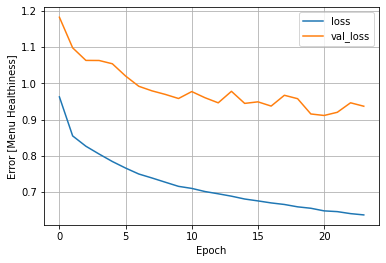

In [ ]:
plot_loss(model_4_history)

In [ ]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_GRU_char")
model_4.evaluate(val_ds)
model_4.evaluate(train_ds)

1778/1778 [==============================] - 5s 3ms/step - loss: 0.8183 - mae: 0.8183


[0.8183445334434509, 0.8183445334434509]



## Model 5 (DL): CNN, word level

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=64,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

inputs = layers.Input(shape=(1,), dtype="string")
x = word_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x= layers.Dropout(0.2)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1)(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D_word")

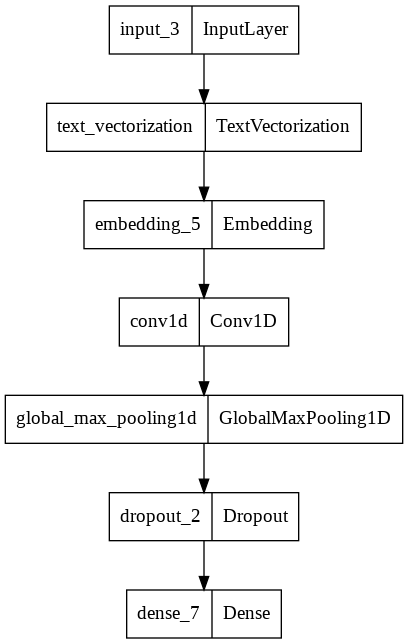

In [ ]:
plot_model(model_5)

In [ ]:
model_5.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())
model_5_history = model_5.fit(train_ds_word, epochs=25, validation_data =val_ds_word,
                              callbacks=[create_model_checkpoint(model_name=model_5.name), early_stopping])

Epoch 1/25
1778/1778 [==============================] - ETA: 0s - loss: 1.3069INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


1778/1778 [==============================] - 10s 5ms/step - loss: 1.3069 - val_loss: 1.2526
Epoch 2/25
1771/1778 [============================>.] - ETA: 0s - loss: 0.9912INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


1778/1778 [==============================] - 7s 4ms/step - loss: 0.9906 - val_loss: 1.0690
Epoch 3/25
1775/1778 [============================>.] - ETA: 0s - loss: 0.9129INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


1778/1778 [==============================] - 7s 4ms/step - loss: 0.9125 - val_loss: 1.0165
Epoch 4/25
1772/1778 [============================>.] - ETA: 0s - loss: 0.8387INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


1778/1778 [==============================] - 10s 5ms/step - loss: 0.8387 - val_loss: 0.9764
Epoch 5/25
1771/1778 [============================>.] - ETA: 0s - loss: 0.7825INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


1778/1778 [==============================] - 12s 6ms/step - loss: 0.7824 - val_loss: 0.9644
Epoch 6/25
1778/1778 [==============================] - 11s 6ms/step - loss: 0.7349 - val_loss: 1.0064
Epoch 7/25
1778/1778 [==============================] - 6s 4ms/step - loss: 0.7075 - val_loss: 1.0013
Epoch 8/25
1778/1778 [==============================] - 7s 4ms/step - loss: 0.6380 - val_loss: 0.9878


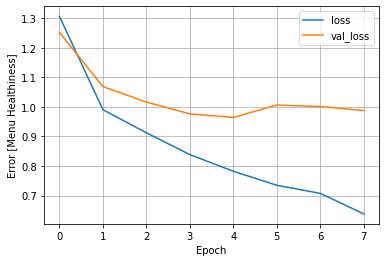

In [ ]:
plot_loss(model_5_history)

In [ ]:
model_evaluation("model_5_Conv1D_word")

results from the training
1778/1778 [==============================] - 4s 2ms/step - loss: 0.7364
results from the validation set
85/85 [==============================] - 0s 2ms/step - loss: 0.9644
results from the test set
85/85 [==============================] - 0s 2ms/step - loss: 0.9665


## Model 6: CNN character level

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)

inputs = tf.keras.Input(shape=(sequence_length), dtype="int64")

x = layers.Embedding(max_features,output_dim=64,embeddings_initializer="uniform",
                                     name="embedding_6")(inputs)

x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.2)(x)
#x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1)(x)
model_6 = tf.keras.Model(inputs, outputs, name="model_6_CNN_char")
model_6.summary()

Model: "model_6_CNN_char"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 57)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 57, 64)            2496      
                                                                 
 conv1d_2 (Conv1D)           (None, 53, 32)            10272     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_32 (Dense)            (None, 1)                 33        
                                                  

In [ ]:
model_6.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())
model_6_history = model_6.fit(train_ds, epochs=25, validation_data = val_ds,
                              callbacks=[create_model_checkpoint(model_name=model_6.name), early_stopping])

Epoch 1/25
1777/1778 [============================>.] - ETA: 0s - loss: 1.3928INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


1778/1778 [==============================] - 6s 3ms/step - loss: 1.3924 - val_loss: 1.4018
Epoch 2/25
1768/1778 [============================>.] - ETA: 0s - loss: 1.1142INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


1778/1778 [==============================] - 6s 3ms/step - loss: 1.1124 - val_loss: 1.2432
Epoch 3/25
1778/1778 [==============================] - 5s 3ms/step - loss: 1.0622 - val_loss: 1.3555
Epoch 4/25
1773/1778 [============================>.] - ETA: 0s - loss: 1.0194INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


1778/1778 [==============================] - 6s 3ms/step - loss: 1.0186 - val_loss: 1.0957
Epoch 5/25
1778/1778 [==============================] - 5s 3ms/step - loss: 0.9963 - val_loss: 1.1292
Epoch 6/25
1766/1778 [============================>.] - ETA: 0s - loss: 1.0967INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


1778/1778 [==============================] - 6s 3ms/step - loss: 1.0963 - val_loss: 0.9875
Epoch 7/25
1770/1778 [============================>.] - ETA: 0s - loss: 0.9928INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


1778/1778 [==============================] - 6s 3ms/step - loss: 0.9919 - val_loss: 0.9500
Epoch 8/25
1778/1778 [==============================] - 5s 3ms/step - loss: 0.8789 - val_loss: 0.9672
Epoch 9/25
1767/1778 [============================>.] - ETA: 0s - loss: 0.9275INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


1778/1778 [==============================] - 6s 4ms/step - loss: 0.9259 - val_loss: 0.9336
Epoch 10/25
1778/1778 [==============================] - 5s 3ms/step - loss: 0.8974 - val_loss: 0.9411
Epoch 11/25
1778/1778 [==============================] - 5s 3ms/step - loss: 0.9157 - val_loss: 0.9563
Epoch 12/25
1778/1778 [==============================] - 5s 3ms/step - loss: 0.9103 - val_loss: 0.9419


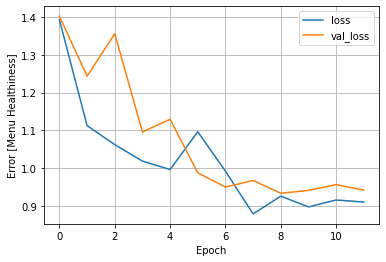

In [ ]:
plot_loss(model_6_history)

In [ ]:
model_6 = tf.keras.models.load_model("model_experiments/model_6_CNN_char")
model_6.evaluate(val_ds)
model_6.evaluate(train_ds)

1778/1778 [==============================] - 3s 2ms/step - loss: 0.8879


0.8879064321517944

## Model 7 (DL): Transfer learning ULM

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
# !pip install tensorflow_text
import tensorflow_text as text

In [ ]:
ulmfit = hub.load('https://tfhub.dev/edrone/ulmfit/en/sp35k_uncased/1')
encoder = hub.KerasLayer(ulmfit.signatures['string_encoder'], trainable= False, name = "universal_language_model")

In [ ]:
input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string)
enc_out = encoder(input_layer) # the output is a dict of tensors with keys 'output_rows' and 'output_flat'
enc_out_ragged = tf.RaggedTensor.from_row_splits(enc_out['output_flat'],   # converting to RaggedTensor
                                                 enc_out['output_rows'])
vector_average = tf.reduce_mean(enc_out_ragged, axis=1) # rather than use the last hidden state, we take the average
                                                        # value of each dimension in a sequence
dense = tf.keras.layers.Dense(64, activation='relu')(vector_average)
dense = tf.keras.layers.Dense(64,activation="relu")(dense)
dense = tf.keras.layers.Dense(1)(dense)
model_7 = tf.keras.models.Model(inputs=encoder.input, outputs=dense,name="Model_7_ulmfit")
model_7.summary()

Model: "Model_7_ulmfit"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 universal_language_model (Kera  {'output_rows': (No  34262464   ['input_7[0][0]']                
 sLayer)                        ne,),                                                             
                                 'output_flat': (No                                               
                                ne, 400)}                                                         
                                                                                                  
 tf.RaggedTensor.from_row_split  (None, None, 400)   0           ['universal_language

In [ ]:
checkpoint_path = "model_7/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

create_model_checkpoint2=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, # create filepath to save model
                                                            save_best_only=True, verbose=0,
                                                            save_weights_only=True,
                                                            monitor = 'val_loss') # save only the best model to file


In [ ]:
model_7.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())

initial_epochs = 25
model_7_history = model_7.fit(x=X_train, y=y_train,
                              epochs=initial_epochs,validation_data=(X_val, y_val),
                                                                     callbacks=[create_model_checkpoint2('Model_7_ULMFit_word'),early_stopping])

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/model_2/AWD_RNN1/RaggedToTensor/RaggedTensorToTensor_grad/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradients/model_2/AWD_RNN1/RaggedToTensor/RaggedTensorToTensor_grad/boolean_mask/GatherV2:0", shape=(None, 400), dtype=float32), dense_shape=Tensor("gradients/model_2/AWD_RNN1/RaggedToTensor/RaggedTensorToTensor_grad/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


1779/1779 [==============================] - 126s 66ms/step - loss: 1.0756 - val_loss: 1.0521
Epoch 2/25
1779/1779 [==============================] - 115s 65ms/step - loss: 0.9569 - val_loss: 1.0168
Epoch 3/25
1779/1779 [==============================] - 125s 71ms/step - loss: 0.9378 - val_loss: 1.0143
Epoch 4/25
1779/1779 [==============================] - 110s 62ms/step - loss: 0.9182 - val_loss: 0.9786
Epoch 5/25
1779/1779 [==============================] - 110s 62ms/step - loss: 0.9113 - val_loss: 0.9710
Epoch 6/25
1779/1779 [==============================] - 109s 61ms/step - loss: 0.8989 - val_loss: 0.9643
Epoch 7/25
1779/1779 [==============================] - 109s 61ms/step - loss: 0.8913 - val_loss: 0.9695
Epoch 8/25
1779/1779 [==============================] - 109s 61ms/step - loss: 0.8828 - val_loss: 0.9589
Epoch 9/25
1779/1779 [==============================] - 109s 61ms/step - loss: 0.8768 - val_loss: 0.9524
Epoch 10/25
1779/1779 [==============================] - 131s 74ms

In [ ]:
model_7.evaluate(X_test,y_test)

86/86 [==============================] - 3s 38ms/step - loss: 0.9743


0.9743375182151794

In [ ]:
model_7.evaluate(X_train, y_train)

1779/1779 [==============================] - 43s 24ms/step - loss: 0.8597


0.8597214818000793

In [ ]:
# fine tuning the model

fine_tune_epochs = initial_epochs + 25

model_7.trainable = True

model_7.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001))

model_7_finetune_history = model_7.fit(x=X_train, y=y_train, epochs=fine_tune_epochs,
                                       initial_epoch = model_7_history.epoch[-1], validation_data=(X_val, y_val),
                                       callbacks=[create_model_checkpoint2])

Epoch 12/50
1779/1779 [==============================] - 267s 148ms/step - loss: 0.8571 - val_loss: 0.8732
Epoch 13/50
1779/1779 [==============================] - 260s 146ms/step - loss: 0.7847 - val_loss: 0.8486
Epoch 14/50
1779/1779 [==============================] - 236s 132ms/step - loss: 0.7404 - val_loss: 0.8473
Epoch 15/50
1779/1779 [==============================] - 232s 131ms/step - loss: 0.7030 - val_loss: 0.8608
Epoch 16/50
1779/1779 [==============================] - 231s 130ms/step - loss: 0.6682 - val_loss: 0.8466
Epoch 17/50
1779/1779 [==============================] - 233s 131ms/step - loss: 0.6385 - val_loss: 0.8416
Epoch 18/50
1779/1779 [==============================] - 232s 130ms/step - loss: 0.6133 - val_loss: 0.8468
Epoch 19/50
1779/1779 [==============================] - 232s 131ms/step - loss: 0.5893 - val_loss: 0.8462
Epoch 20/50
1779/1779 [==============================] - 232s 130ms/step - loss: 0.5721 - val_loss: 0.8551
Epoch 21/50
1779/1779 [==============

KeyboardInterrupt: ignored

In [ ]:
model_7.load_weights('model_7/cp.ckpt')

In [ ]:
model_7.evaluate(X_test,y_test)

86/86 [==============================] - 4s 42ms/step - loss: 0.8577


0.8577132225036621

In [ ]:
model_7.evaluate(X_train,y_train)

1779/1779 [==============================] - 57s 32ms/step - loss: 0.6025


0.6025400757789612

In [ ]:
pd.DataFrame(zip(names_to_predict,model_7.predict(names_to_predict2)),columns=['rest_name','predicted_score'])

1/1 [==============================] - 1s 616ms/step


,rest_name,predicted_score
0,X's fish & chip shop,[5.371912]
1,Yuru's Pizza & Kebab,[5.280836]
2,Yuru's Chinese Takeaways,[6.7427893]
3,Yuru's Sushi Takeaways,[7.0998163]
4,Yuru's Sushi Restaurant,[8.079787]
5,Yuru's Cocktail Bar,[6.366557]
6,Cambridge Oven,[6.6594915]
7,Yo!Sushi,[8.812287]
8,Starbucks,[7.135051]
9,Vanderlyle,[6.4684916]


## Model 8 (DL): Adding hygine ratings

In [ ]:
train_ds_hr = clean_data(pd.read_csv('train_smogn_whr.csv'))
test_ds_hr = clean_data(pd.read_csv('test_smogn_whr.csv'))

In [ ]:
test_ds_hr, val_ds_hr = train_test_split(test_ds_hr, test_size = 0.5, random_state=42)

In [ ]:
train_ds_hr.columns

Index(['Unnamed: 0', 'index', 'Restaurant ID', 'Desserts', 'Vegetables',
       'Salads', 'Chips', 'Water', 'Milk', 'Special Offers', 'rest_name',
       'address', 'cuisines', 'url', 'rating_review', 'price_avg', 'price_min',
       'price_max', 'postcode', 'postcode_district', 'specialOffers', 'chips',
       'salads', 'predict', 'rating2', 'hr'],
      dtype='object')

In [ ]:
# focus on England only: restaurants with hyginene ratings

def clean_data_hr(data):
 data = data[data['hr'].notnull() & data['hr'].str.contains('0|1|2|3|4|5')]
 data['hr_rating'] = data.hr.astype("float32")
 data['ascii_name_fix'] = data.rest_name.apply(lambda x: rest_name_cleaning(x))
 return data[['ascii_name_fix', 'hr_rating']], data.predict

In [ ]:
X_train_hr, y_train_hr = clean_data_hr(train_ds_hr)
X_val_hr, y_val_hr = clean_data_hr(val_ds_hr)
X_test_hr, y_test_hr = clean_data_hr(test_ds_hr)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


word vectorization

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
# Setup text vectorization with custom variables
max_vocab_length=20000
max_length = 10 # max length our sequences will be (e.g. how many words from the restaurant name does our model see?)

word_vectorizer = TextVectorization(output_mode="int",
                                    max_tokens = max_vocab_length,
                                    split = "whitespace",
                                    standardize ="lower_and_strip_punctuation",
                                    output_sequence_length=max_length)
word_vectorizer.adapt(X_train_hr['ascii_name_fix'])

In [ ]:
from collections import Counter
Counter(X_train_hr['hr_rating'])

Counter({0.0: 34, 1.0: 614, 2.0: 719, 3.0: 4116, 4.0: 6020, 5.0: 14167})

In [ ]:
X_train_hr

,ascii_name_fix,hr_rating
12347,tj's,4.0
12348,lady tee's nigerian foods,4.0
12349,proper burger experience,4.0
12350,nelly's,5.0
12351,karma restaurant,4.0
...,...,...
45086,the star of sall,5.0
45087,bigmouths kitchen,5.0
45088,ayesha's tandoori,3.0
45089,aroma indian takeaway,5.0


In [ ]:
#import tensorflow as tf
#from tensorflow.keras import layers

# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)

nlp_input = tf.keras.Input(shape=(10,), name='nlp_input')
#nlp_token = word_vectorizer(nlp_input)
hygiene_input = tf.keras.Input(shape=(1,), name='hygiene_input')
#hygiene_out = layers.Dense(64, activation = 'relu')(hygiene_input)
emb = layers.Embedding(output_dim=64, input_dim=max_vocab_length, input_length=max_length)(nlp_input)
nlp_out = layers.GRU(64)(emb)
x = tf.concat([nlp_out, hygiene_input],1)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(1)(x)
model_8 = tf.keras.Model(inputs=[nlp_input , hygiene_input], outputs=[x],name ='Model_8_hr_word_GRU')

In [ ]:
model_8.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())

model_8.summary()

Model: "Model_8_hr_word_GRU"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 10, 64)       1280000     ['nlp_input[0][0]']              
                                                                                                  
 gru (GRU)                      (None, 64)           24960       ['embedding[0][0]']              
                                                                                                  
 hygiene_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                

In [ ]:
X_train_hr_name = word_vectorizer(tf.convert_to_tensor(X_train_hr['ascii_name_fix'].values))
print(X_train_hr_name.shape)

X_val_hr_name = word_vectorizer(tf.convert_to_tensor(X_val_hr['ascii_name_fix'].values))
print(X_val_hr_name.shape)

X_test_hr_name = word_vectorizer(tf.convert_to_tensor(X_test_hr['ascii_name_fix'].values))
print(X_test_hr_name.shape)

(25670, 10)
(2108, 10)
(2132, 10)


In [ ]:
X_train_hr_hr = X_train_hr['hr_rating'].values
print(X_train_hr_hr.shape)

X_val_hr_hr = X_val_hr['hr_rating'].values
print(X_val_hr_hr.shape)


X_test_hr_hr = X_test_hr['hr_rating'].values
print(X_test_hr_hr.shape)

(25670,)
(2108,)
(2132,)


In [ ]:
model_8_history = model_8.fit([X_train_hr_name,X_train_hr_hr], y_train_hr, epochs=25,
                              validation_data = ([X_val_hr_name,X_val_hr_hr], y_val_hr),
                              callbacks=[create_model_checkpoint(model_name=model_8.name),early_stopping])

Epoch 1/25
802/803 [============================>.] - ETA: 0s - loss: 1.2277

INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


803/803 [==============================] - 35s 40ms/step - loss: 1.2278 - val_loss: 0.8862
Epoch 2/25
801/803 [============================>.] - ETA: 0s - loss: 0.8831

INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


803/803 [==============================] - 32s 40ms/step - loss: 0.8832 - val_loss: 0.8640
Epoch 3/25
802/803 [============================>.] - ETA: 0s - loss: 0.7764

INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


803/803 [==============================] - 23s 29ms/step - loss: 0.7766 - val_loss: 0.8467
Epoch 4/25
803/803 [==============================] - 18s 22ms/step - loss: 0.6978 - val_loss: 0.8507
Epoch 5/25
803/803 [==============================] - 17s 21ms/step - loss: 0.6415 - val_loss: 0.8513
Epoch 6/25
803/803 [==============================] - 17s 21ms/step - loss: 0.6034 - val_loss: 0.8746


In [ ]:
# load the best performing model and then evaluate the performance
model_8 = tf.keras.models.load_model("/content/model_experiments/Model_8_hr_word_GRU")

In [ ]:
model_8.evaluate([X_train_hr_name,X_train_hr_hr], y_train_hr)

803/803 [==============================] - 3s 3ms/step - loss: 0.6773


0.6773425340652466

In [ ]:
model_8.evaluate([X_test_hr_name,X_test_hr_hr], y_test_hr)

67/67 [==============================] - 0s 4ms/step - loss: 0.8459


0.8458724021911621

## Model 9: add hygiene rating, character level GRU

In [ ]:
# set up character level tokenization
max_features = 39          # Number of distinct chars
sequence_length = 57       # Input sequence size

def char_split(input_data):
  return(tf.strings.unicode_split(input_data,'UTF-8'))

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    split=char_split, # word_split or char_split
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [ ]:
vectorize_layer.adapt(X_train_hr.ascii_name_fix)

In [ ]:
X_train_hr_name_char = vectorize_layer(tf.convert_to_tensor(X_train_hr['ascii_name_fix'].values))
X_val_hr_name_char = vectorize_layer(tf.convert_to_tensor(X_val_hr['ascii_name_fix'].values))
X_test_hr_name_char = vectorize_layer(tf.convert_to_tensor(X_test_hr['ascii_name_fix'].values))

In [ ]:
nlp_input = tf.keras.Input(shape=(sequence_length,), name='nlp_input')
#nlp_token = word_vectorizer(nlp_input)
hygiene_input = tf.keras.Input(shape=(1,), name='hygiene_input')
#hygiene_out = layers.Dense(64, activation = 'relu')(hygiene_input)
emb = layers.Embedding(output_dim=64, input_dim = max_features)(nlp_input)
nlp_out = layers.GRU(64)(emb)
x = tf.concat([nlp_out, hygiene_input],1)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(1)(x)
model_9 = tf.keras.Model(inputs=[nlp_input , hygiene_input], outputs=[x], name = 'Model_9_hr_char_GRU')

In [ ]:
model_9.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ['mae','mean_absolute_percentage_error'])

model_9.summary()

Model: "Model_9_hr_char_GRU"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 57)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 57, 64)       2496        ['nlp_input[0][0]']              
                                                                                                  
 gru_1 (GRU)                    (None, 64)           24960       ['embedding_1[0][0]']            
                                                                                                  
 hygiene_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                

In [ ]:
model_9_history = model_9.fit([X_train_hr_name_char,X_train_hr.hr_rating], y_train_hr, epochs=25,
                              validation_data = ([X_val_hr_name_char,X_val_hr.hr_rating], y_val_hr),
                              callbacks=[create_model_checkpoint(model_name=model_9.name),early_stopping])

Epoch 1/25
802/803 [============================>.] - ETA: 0s - loss: 1.4483 - mae: 1.4483 - mean_absolute_percentage_error: 22209816.0000

INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


803/803 [==============================] - 65s 74ms/step - loss: 1.4483 - mae: 1.4483 - mean_absolute_percentage_error: 22204626.0000 - val_loss: 1.0645 - val_mae: 1.0645 - val_mean_absolute_percentage_error: 14909514.0000
Epoch 2/25
803/803 [==============================] - ETA: 0s - loss: 1.1904 - mae: 1.1904 - mean_absolute_percentage_error: 21903424.0000

INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


803/803 [==============================] - 50s 62ms/step - loss: 1.1904 - mae: 1.1904 - mean_absolute_percentage_error: 21903424.0000 - val_loss: 1.0268 - val_mae: 1.0268 - val_mean_absolute_percentage_error: 14242718.0000
Epoch 3/25
803/803 [==============================] - ETA: 0s - loss: 1.1498 - mae: 1.1498 - mean_absolute_percentage_error: 21036894.0000

INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


803/803 [==============================] - 34s 43ms/step - loss: 1.1498 - mae: 1.1498 - mean_absolute_percentage_error: 21036894.0000 - val_loss: 0.9847 - val_mae: 0.9847 - val_mean_absolute_percentage_error: 14178095.0000
Epoch 4/25
803/803 [==============================] - 29s 36ms/step - loss: 1.1087 - mae: 1.1087 - mean_absolute_percentage_error: 20272106.0000 - val_loss: 0.9891 - val_mae: 0.9891 - val_mean_absolute_percentage_error: 14379782.0000
Epoch 5/25
803/803 [==============================] - ETA: 0s - loss: 1.0739 - mae: 1.0739 - mean_absolute_percentage_error: 19168034.0000

INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


803/803 [==============================] - 36s 44ms/step - loss: 1.0739 - mae: 1.0739 - mean_absolute_percentage_error: 19168034.0000 - val_loss: 0.9439 - val_mae: 0.9439 - val_mean_absolute_percentage_error: 12619416.0000
Epoch 6/25
803/803 [==============================] - 29s 37ms/step - loss: 1.0452 - mae: 1.0452 - mean_absolute_percentage_error: 17956110.0000 - val_loss: 0.9584 - val_mae: 0.9584 - val_mean_absolute_percentage_error: 12814822.0000
Epoch 7/25
802/803 [============================>.] - ETA: 0s - loss: 1.0229 - mae: 1.0229 - mean_absolute_percentage_error: 16966238.0000

INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


803/803 [==============================] - 34s 43ms/step - loss: 1.0229 - mae: 1.0229 - mean_absolute_percentage_error: 16962272.0000 - val_loss: 0.8972 - val_mae: 0.8972 - val_mean_absolute_percentage_error: 12246195.0000
Epoch 8/25
803/803 [==============================] - ETA: 0s - loss: 1.0002 - mae: 1.0002 - mean_absolute_percentage_error: 16750754.0000

INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


803/803 [==============================] - 35s 43ms/step - loss: 1.0002 - mae: 1.0002 - mean_absolute_percentage_error: 16750754.0000 - val_loss: 0.8891 - val_mae: 0.8891 - val_mean_absolute_percentage_error: 11937499.0000
Epoch 9/25
802/803 [============================>.] - ETA: 0s - loss: 0.9796 - mae: 0.9796 - mean_absolute_percentage_error: 16717521.0000

INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


803/803 [==============================] - 38s 47ms/step - loss: 0.9795 - mae: 0.9795 - mean_absolute_percentage_error: 16713614.0000 - val_loss: 0.8888 - val_mae: 0.8888 - val_mean_absolute_percentage_error: 11710315.0000
Epoch 10/25
803/803 [==============================] - ETA: 0s - loss: 0.9626 - mae: 0.9626 - mean_absolute_percentage_error: 16705172.0000

INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


803/803 [==============================] - 34s 42ms/step - loss: 0.9626 - mae: 0.9626 - mean_absolute_percentage_error: 16705172.0000 - val_loss: 0.8762 - val_mae: 0.8762 - val_mean_absolute_percentage_error: 11738171.0000
Epoch 11/25
803/803 [==============================] - 29s 37ms/step - loss: 0.9479 - mae: 0.9479 - mean_absolute_percentage_error: 16358446.0000 - val_loss: 0.9019 - val_mae: 0.9019 - val_mean_absolute_percentage_error: 11864054.0000
Epoch 12/25
803/803 [==============================] - ETA: 0s - loss: 0.9289 - mae: 0.9289 - mean_absolute_percentage_error: 16323571.0000

INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


803/803 [==============================] - 36s 44ms/step - loss: 0.9289 - mae: 0.9289 - mean_absolute_percentage_error: 16323571.0000 - val_loss: 0.8438 - val_mae: 0.8438 - val_mean_absolute_percentage_error: 10822085.0000
Epoch 13/25
803/803 [==============================] - 31s 39ms/step - loss: 0.9152 - mae: 0.9152 - mean_absolute_percentage_error: 16137572.0000 - val_loss: 0.8443 - val_mae: 0.8443 - val_mean_absolute_percentage_error: 10860880.0000
Epoch 14/25
803/803 [==============================] - 29s 37ms/step - loss: 0.9050 - mae: 0.9050 - mean_absolute_percentage_error: 15845345.0000 - val_loss: 0.8551 - val_mae: 0.8551 - val_mean_absolute_percentage_error: 11169121.0000
Epoch 15/25
803/803 [==============================] - 29s 36ms/step - loss: 0.8926 - mae: 0.8926 - mean_absolute_percentage_error: 15705995.0000 - val_loss: 0.8462 - val_mae: 0.8462 - val_mean_absolute_percentage_error: 11448603.0000


In [ ]:
# load the best performing model and then evaluate the performance
model_9 = tf.keras.models.load_model("/content/model_experiments/Model_9_hr_char_GRU")

In [ ]:
model_9.evaluate([X_train_hr_name_char,X_train_hr_hr], y_train_hr)

803/803 [==============================] - 8s 10ms/step - loss: 0.8976 - mae: 0.8976 - mean_absolute_percentage_error: 15354120.0000


[0.8976129293441772, 0.8976129293441772, 15354120.0]

In [ ]:
model_9.evaluate([X_test_hr_name_char,X_test_hr_hr], y_test_hr)

67/67 [==============================] - 1s 10ms/step - loss: 0.8738 - mae: 0.8738 - mean_absolute_percentage_error: 8607817.0000


[0.8738011121749878, 0.8738011121749878, 8607817.0]

## Model 10: restaurant name only, combining character and word level

reference: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [2]:
train_chars = [split_chars(sentence) for sentence in X_train]
val_chars = [split_chars(sentence) for sentence in X_val]
test_chars = [split_chars(sentence) for sentence in X_test]

In [ ]:
NUM_CHAR_TOKENS = 39
output_seq_char_len = 57

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(1)(final_dropout)

# 5. Construct model with char and token inputs
model_10 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_10_token_and_char_embeddings")

In [ ]:
# Compile token char model
model_10.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((X_train, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(y_train) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((X_val, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(y_val)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
test_char_token_data = tf.data.Dataset.from_tensor_slices((X_test, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset, test_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.string, name=None), TensorSpec(shape=(None, None), dtype=tf.string, name=None)), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model on tokens and chars
model_10_history = model_10.fit(train_char_token_dataset, # train on dataset of token and characters
                              epochs=25,
                              validation_data=val_char_token_dataset,
                              callbacks=[create_model_checkpoint(model_name=model_10.name), early_stopping])

Epoch 1/25
1779/1779 [==============================] - ETA: 0s - loss: 1.2383

INFO:tensorflow:Assets written to: model_experiments/model_10_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_token_and_char_embeddings/assets


1779/1779 [==============================] - 73s 35ms/step - loss: 1.2383 - val_loss: 1.9037
Epoch 2/25
1779/1779 [==============================] - 28s 16ms/step - loss: 0.9830 - val_loss: 2.0022
Epoch 3/25
1778/1779 [============================>.] - ETA: 0s - loss: 0.9722

INFO:tensorflow:Assets written to: model_experiments/model_10_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_token_and_char_embeddings/assets


1779/1779 [==============================] - 50s 28ms/step - loss: 0.9721 - val_loss: 1.8052
Epoch 4/25
1778/1779 [============================>.] - ETA: 0s - loss: 0.9275

INFO:tensorflow:Assets written to: model_experiments/model_10_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_token_and_char_embeddings/assets


1779/1779 [==============================] - 62s 35ms/step - loss: 0.9275 - val_loss: 1.7819
Epoch 5/25
1778/1779 [============================>.] - ETA: 0s - loss: 0.9246

INFO:tensorflow:Assets written to: model_experiments/model_10_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_token_and_char_embeddings/assets


1779/1779 [==============================] - 49s 27ms/step - loss: 0.9246 - val_loss: 1.5559
Epoch 6/25
1779/1779 [==============================] - 29s 16ms/step - loss: 0.8819 - val_loss: 1.8058
Epoch 7/25
1779/1779 [==============================] - 28s 16ms/step - loss: 0.8814 - val_loss: 1.7461
Epoch 8/25
1779/1779 [==============================] - 31s 17ms/step - loss: 0.8685 - val_loss: 1.5857


In [ ]:
model_10 = tf.keras.models.load_model("/content/model_experiments/model_10_token_and_char_embeddings")

In [ ]:
model_10.evaluate(train_char_token_dataset)

1779/1779 [==============================] - 21s 11ms/step - loss: 1.9308


1.9308134317398071

In [ ]:
plot_model(model_10)

NameError: ignored

In [ ]:
test_char_token_data = tf.data.Dataset.from_tensor_slices((X_test, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_10.evaluate(test_char_token_dataset)

86/86 [==============================] - 3s 19ms/step - loss: 1.5824


1.5823695659637451

### now start fine tuning

In [ ]:
for layer in model_10.layers:
  print(layer.name, layer.trainable)

char_input True
token_input True
char_vectorizer True
universal_sentence_encoder False
char_embed True
dense True
bidirectional True
token_char_hybrid True
dropout True
dense_1 True
dropout_1 True
dense_2 True


In [ ]:
# make the whole model trainable
model_10.trainable = True

In [ ]:
for layer in model_10.layers:
  print(layer.name, layer.trainable)

char_input True
token_input True
char_vectorizer True
universal_sentence_encoder True
char_embed True
dense True
bidirectional True
token_char_hybrid True
dropout True
dense_1 True
dropout_1 True
dense_2 True


In [ ]:
# recompile the model
model_10.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
fine_tune_epochs = 8 + 25

history_fine_model_10 = model_10.fit(train_char_token_dataset, epochs = fine_tune_epochs,
                                     validation_data = test_char_token_dataset,
                                     initial_epoch = model_10_history.epoch[-1],
                                     callbacks =[create_model_checkpoint(model_name=model_10.name), early_stopping] )

Epoch 8/33
1779/1779 [==============================] - ETA: 0s - loss: 0.9364

INFO:tensorflow:Assets written to: model_experiments/model_10_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_token_and_char_embeddings/assets


1779/1779 [==============================] - 322s 176ms/step - loss: 0.9364 - val_loss: 1.3503
Epoch 9/33
1779/1779 [==============================] - 278s 156ms/step - loss: 0.8884 - val_loss: 1.3801
Epoch 10/33
1779/1779 [==============================] - 277s 156ms/step - loss: 0.8699 - val_loss: 2.6421
Epoch 11/33
1779/1779 [==============================] - ETA: 0s - loss: 0.8254

INFO:tensorflow:Assets written to: model_experiments/model_10_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_token_and_char_embeddings/assets


1779/1779 [==============================] - 309s 174ms/step - loss: 0.8254 - val_loss: 1.2013
Epoch 12/33
1779/1779 [==============================] - 276s 155ms/step - loss: 0.7859 - val_loss: 1.2563
Epoch 13/33
1779/1779 [==============================] - 277s 155ms/step - loss: 0.7762 - val_loss: 1.8819
Epoch 14/33
1779/1779 [==============================] - 276s 155ms/step - loss: 0.7479 - val_loss: 1.4682


In [ ]:
model_10 = tf.keras.models.load_model("/content/model_experiments/model_10_token_and_char_embeddings")

In [ ]:
model_10.evaluate(train_char_token_dataset)

1779/1779 [==============================] - 23s 12ms/step - loss: 1.2918


1.2917646169662476

In [ ]:
model_10.evaluate(test_char_token_dataset)

86/86 [==============================] - 1s 12ms/step - loss: 1.2013


1.2012683153152466

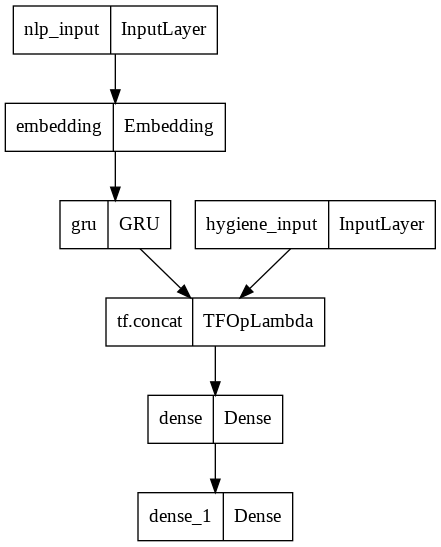

In [ ]:
plot_model(model_8)

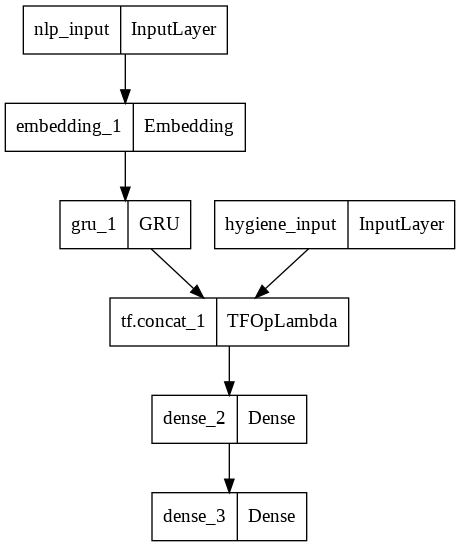

In [ ]:
plot_model(model_9)